In [8]:
import pandas as pd

infn = "/Users/mingay/coding/market_research/patents_pages1to120.tsv"
df = pd.read_csv(infn, sep="\t", header=None)
df = df.sort_values(by=5, ascending=False).reset_index(drop=True)


In [12]:
df.dtypes

0     object
1     object
2     object
3     object
4    float64
5     object
6     object
7     object
dtype: object

In [ ]:
print(len(df))
print(len(df.dropna()))
df.head(3)
df.describe()

2400
2191


,4
count,2240.000000
mean,2017.525000
std,4.154594
min,1994.000000
25%,2017.000000
50%,2019.000000
75%,2019.000000
max,2025.000000


In [ ]:
# pip install openai pandas numpy scikit-learn umap-learn matplotlib
import os,json,math,re,sys
import numpy as np,pandas as pd,matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import os
os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [16]:
# pip install tiktoken pandas
import json,pandas as pd,tiktoken
enc=tiktoken.get_encoding("cl100k_base")

path="/Users/mingay/coding/market_research/patents_page20to80.json"
df=pd.DataFrame(json.load(open(path)))
titles=df["title"].fillna("").astype(str)

tokens=sum(len(enc.encode(t)) for t in titles)
n=len(titles);avg=tokens/max(1,n)

cost_large=tokens/1e6*0.13      # text-embedding-3-large
cost_small=tokens/1e6*0.02      # text-embedding-3-small
cost_large_batch=cost_large/2   # Batch API
cost_small_batch=cost_small/2

print(f"items={n} tokens={tokens} avg/title≈{avg:.1f}")
print(f"3-large:  ${cost_large:.4f}   (batch ${cost_large_batch:.4f})")
print(f"3-small:  ${cost_small:.4f}   (batch ${cost_small_batch:.4f})")

items=1220 tokens=44900 avg/title≈36.8
3-large:  $0.0058   (batch $0.0029)
3-small:  $0.0009   (batch $0.0004)


In [25]:
# # Add cluster descriptions as a new column to df_out
# cluster_descriptions = {
#     0: "Wireless systems, error correction, and signal processing innovations",
#     1: "Medical and environmental sensors with precision optical systems", 
#     2: "Targeted therapies for neurological, cardiovascular, and cancer diseases",
#     3: "Advanced electronics, antennas, and high-efficiency power systems",
#     4: "Biomechanics, robotics, and advanced tactile feedback devices",
#     5: "Pharmaceutical compositions, nanotech therapies, and molecular delivery",
#     6: "Microfluidics, electromechanics, and smart manufacturing systems",
#     7: "Diagnostic biosensors, fluorescent markers, and bioimaging techniques",
#     8: "AI in imaging, medical diagnostics, and simulation modeling",
#     9: "Printed electronics, optics, and alternative semiconductor materials",
#     10: "Genetic engineering, antibodies, and molecular biology applications",
#     11: "Industrial chemistry, catalysis, and sustainable material processing"
# }

# # Map cluster IDs to descriptions and add as new column
# df_out['cluster_description'] = df_out['cluster'].map(cluster_descriptions)

# df_out.to_csv("patent_titles_embeddings_clusters.csv",index=False)
# print("\nWrote: patent_titles_scatter.png, patent_titles_embeddings_clusters.csv")

/var/folders/vj/n7n4_nm56m53h7q_jwzj_p0r0000gn/T/ipykernel_48546/873993355.py:33: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  kw=df.title.str.contains(rx).astype(int)
/opt/homebrew/Caskroom/miniforge/base/envs/crawl4ai/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


                                                                                                                                                                                                                                     title                          organization patent_number year  def_sim  def_kw  cluster
Kit for building adaptive unmanned defense counter improvised explosive device robots for investigating explosive device threats, has platform comprising computing device, power source, power ports and data ports are mounted to casing                      National Defence     CA2870072 2019 0.439513       1        6
                           Adaptive receiver for military reconnaissance systems, has analog-to-digital converters converting intermediate frequency signal to digital signal and digital processor determining parameters of input signal                      National Defence     CA2400998 2019 0.411816       0        0
           Laser beam missile guidance system,

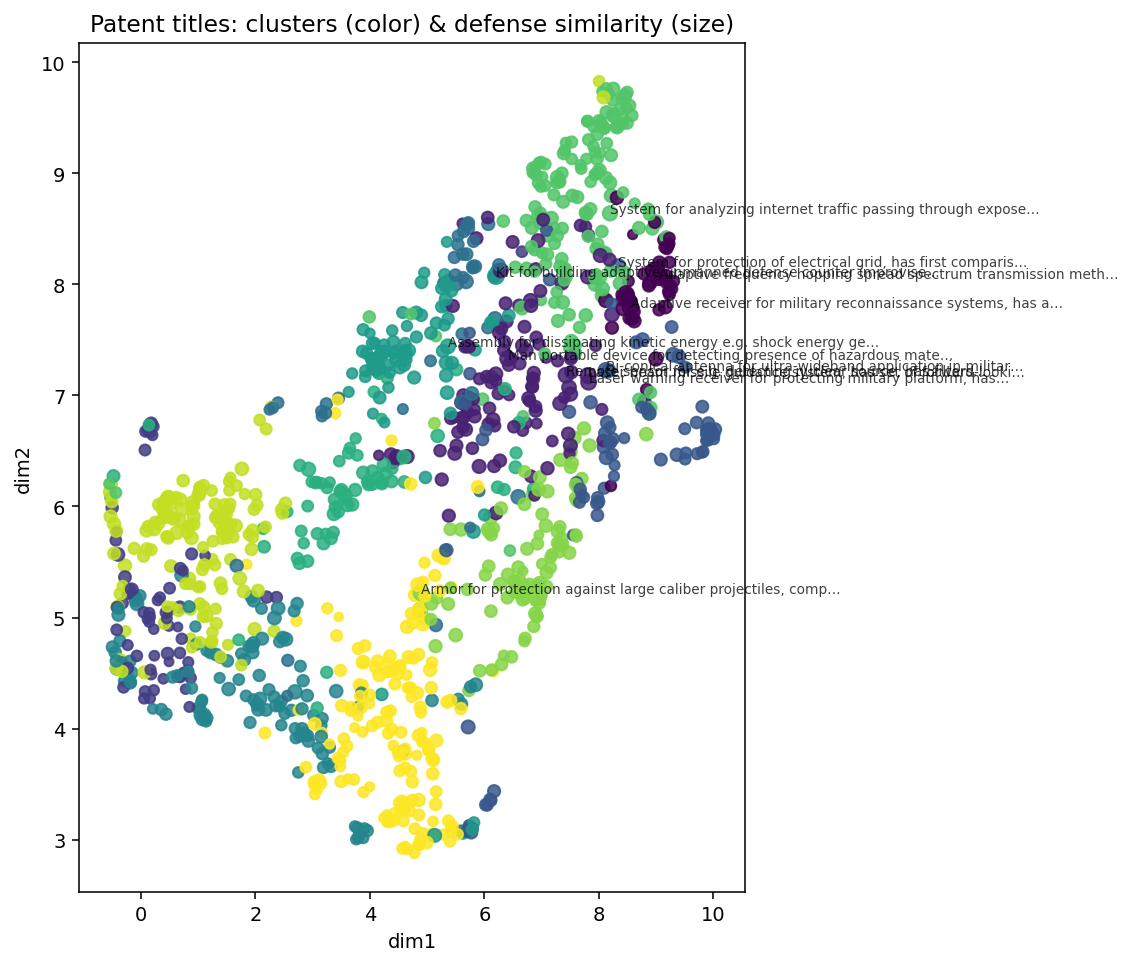

In [17]:

path="/Users/mingay/coding/market_research/patents_page20to80.json"
data=json.load(open(path))
df=pd.DataFrame(data)
df=df.assign(title=df["title"].fillna("").str.strip())
df=df[df.title.ne("")].reset_index(drop=True)

def embed(texts,model="text-embedding-3-large",bs=128):
    vecs=[]
    for i in range(0,len(texts),bs):
        batch=texts[i:i+bs]
        out=client.embeddings.create(model=model,input=batch)
        vecs.extend([e.embedding for e in out.data])
    return np.array(vecs,dtype=np.float32)

titles=df.title.tolist()
X=embed(titles)

# defense similarity (seed words + cosine)
seeds="""
defense defence military security ISR radar sonar EW ECM ELINT SIGINT geospatial
satellite space C4ISR missile rocket warhead propulsion hypersonic guidance inertial
GNSS jamming countermeasure armor armour ballistic ceramic composite body armor
UAV UAS drone UGV UUV counter-drone CUAS targeting surveillance reconnaissance
cyber encryption cryptography post-quantum PQC homomorphic secure enclave
CBRN biosecurity biosurveillance decontamination hardened EMI EMP nuclear
dual-use battlefield munitions small arms ordnance explosives IED EOD
""".split()
seed_vec=embed([" ".join(seeds)]).mean(0,keepdims=True)
def_sim=cosine_similarity(X,seed_vec).ravel()

# simple keyword flag too
rx=re.compile(r"\b(defen[cs]e|militar|radar|sonar|missile|uav|uas|drone|surveillance|cyber|encryption|c4isr|cbnr|cbrn|armor|armour|munition|ordnance|hypersonic|counter-?drone|satellite)\b",re.I)
kw=df.title.str.contains(rx).astype(int)

# choose K
n=len(df);K=max(2,min(12,int(math.sqrt(max(4,n//2)))))
km=MiniBatchKMeans(n_clusters=K,random_state=42,batch_size=256,n_init="auto").fit(X)
labels=km.labels_

# 2D projection
Y=None
try:
    import umap
    Y=umap.UMAP(n_components=2,metric="cosine",random_state=42,min_dist=0.1).fit_transform(X)
except Exception:
    try:
        Y=TSNE(n_components=2,metric="cosine",perplexity=min(30,max(5,n//50)),random_state=42,init="random").fit_transform(X)
    except Exception:
        Y=PCA(n_components=2,random_state=42).fit_transform(X)

df_out=df.assign(cluster=labels,def_sim=def_sim,def_kw=kw,x=Y[:,0],y=Y[:,1])

# quick surface: top likely defense items
top=df_out.sort_values("def_sim",ascending=False).head(25)[["title","organization","patent_number","year","def_sim","def_kw","cluster"]]
print(top.to_string(index=False))

# plot
plt.figure(figsize=(8,7),dpi=140)
sc=plt.scatter(df_out.x,df_out.y,c=df_out.cluster,s=15+120*df_out.def_sim,alpha=0.85)
plt.title("Patent titles: clusters (color) & defense similarity (size)")
plt.xlabel("dim1");plt.ylabel("dim2")
# annotate a few most defense-like
for _,r in df_out.sort_values("def_sim",ascending=False).head(12).iterrows():
    plt.annotate(r.title[:60]+"…",(r.x,r.y),fontsize=7,alpha=0.75)
plt.tight_layout();plt.savefig("patent_titles_scatter.png",bbox_inches="tight")

df_out.to_csv("patent_titles_embeddings_clusters.csv",index=False)
print("\nWrote: patent_titles_scatter.png, patent_titles_embeddings_clusters.csv")

In [18]:
df_out.head(3)

,title,patent_number,organization,patent_type,year,date_added,url,description,cluster,def_sim,def_kw,x,y
0,System and Method for Glucose Sensing using Mi...,US17026452,The University of Waterloo,Patent,2020,2021-03-05,https://ised-isde.canada.ca/ipm-mcpi/patent-br...,A method has been developed that enables insta...,1,0.239154,1,6.772045,6.973671
1,Heterostructure device e.g. buried heterostruc...,WO2022058963,National Research Council Canada,Patent,2020,2023-02-28,https://ised-isde.canada.ca/ipm-mcpi/patent-br...,A heterostructure laser is provided comprising...,9,0.195407,0,6.772932,5.248750
2,METHODS OF TREATING AND/OR PREVENTING ALZHEIME...,WO2022126236,Innovate Calgary,Patent,2020,2025-04-09,https://ised-isde.canada.ca/ipm-mcpi/patent-br...,Methods of treating and/or preventing dysfunct...,2,0.133412,0,0.176118,4.490738


In [21]:
import random

# Open file for writing
with open('cluster_descriptions.txt', 'w') as f:
    for cluster_id in sorted(set(df_out['cluster'])):
        print(f"\n=== Cluster {cluster_id} ===")
        f.write(f"\n=== Cluster {cluster_id} ===\n")
        
        # Get all rows for this cluster
        cluster_data = df_out[df_out['cluster'] == cluster_id]
        
        # Get 3 random descriptions (or all if less than 3)
        sample_size = min(10, len(cluster_data))
        random_samples = cluster_data.sample(n=sample_size, random_state=42)
        
        for i, (idx, row) in enumerate(random_samples.iterrows(), 1):
            description = row['description'][:200] + "..." if len(row['description']) > 200 else row['description']
            print(f"{i}. {description}")
            f.write(f"{i}. {description}\n")
        
        cluster_count = f"Total items in cluster {cluster_id}: {len(cluster_data)}"
        print(cluster_count)
        f.write(cluster_count + "\n")

print(f"\nCluster descriptions written to: cluster_descriptions.txt")


=== Cluster 0 ===
1. System and method embodiments are provided to optimize uplink multiple-input-multiple-output (MIMO) beamforming for uplink and compression for fronthaul links transmission in cloud radio access networ...
2. There is disclosed an apparatus and method for generating a keystream with ideal two-level autocorrelation, which can be efficiently implemented in both software and hardware on mobile devices requiri...
3. The subject application relates to telecommunication networks and more particularly, to a method and system for managing and allocating wireless network resources to optimize User satisfaction. One as...
4. An antenna system including a retro-directive adaptive phased array antenna, comprised of a group of antenna modules. There is a phasing cell in each antenna module that adds a certain amount of phase...
5. Methods and systems for data communication in a distributed computing environment include: providing a first network node associated with a first data

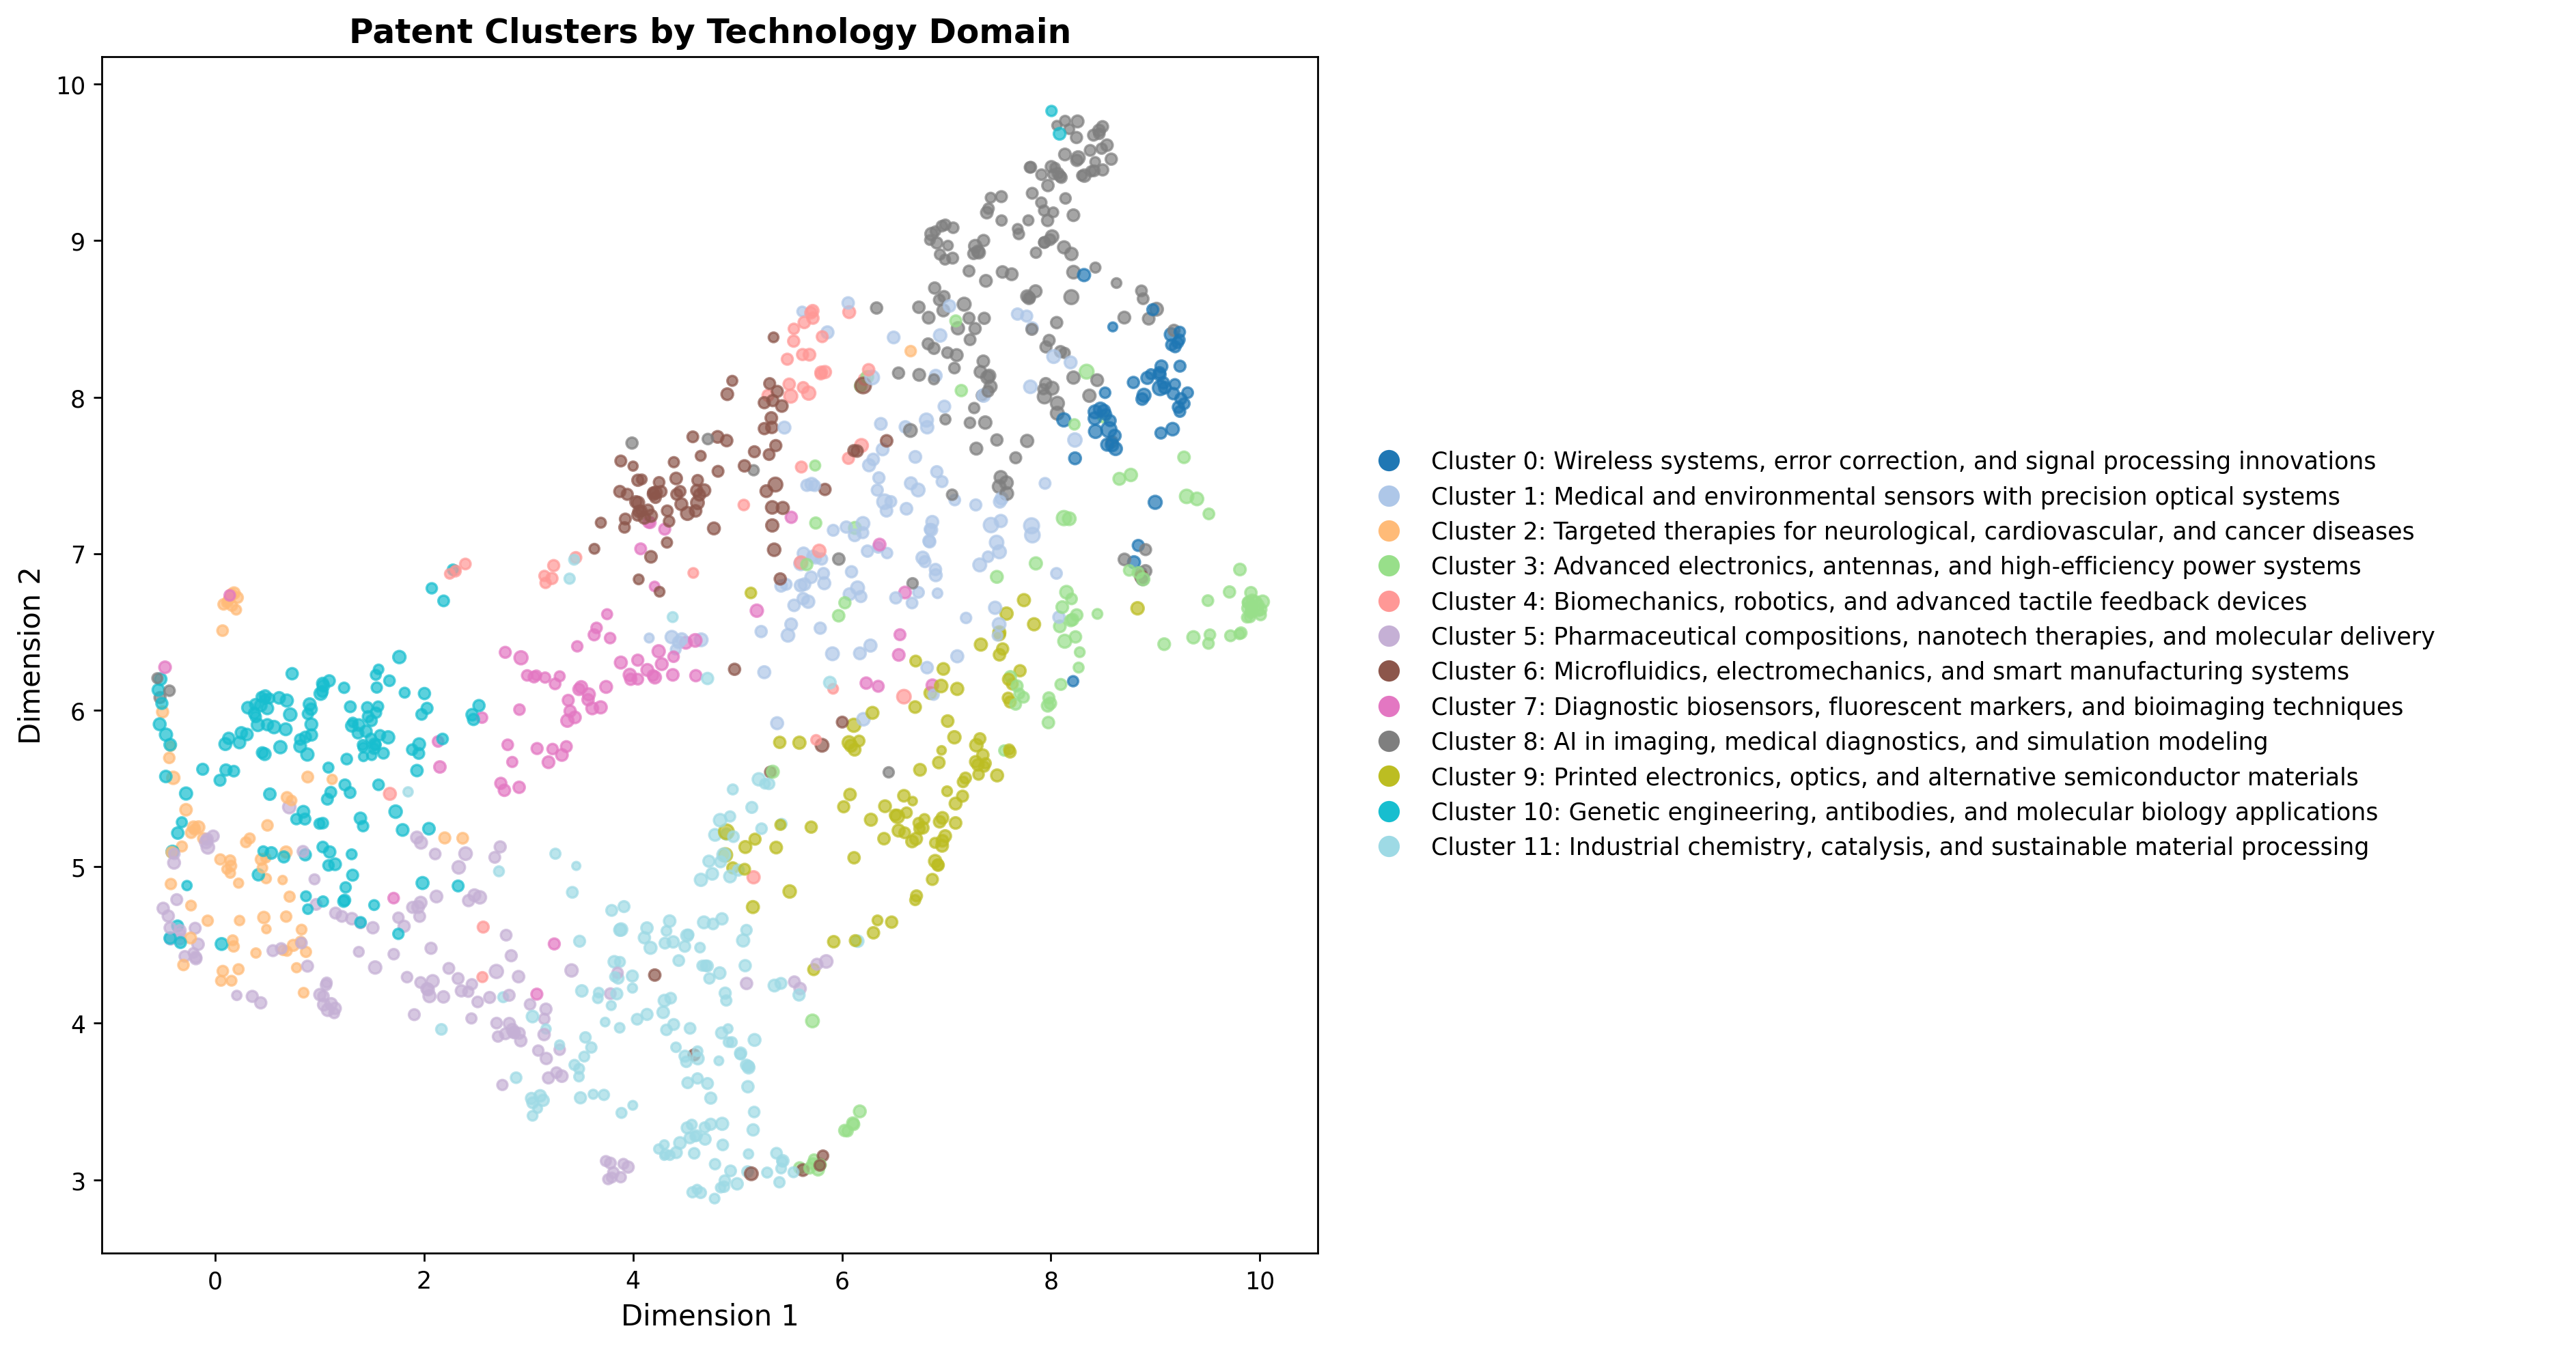

In [23]:
# Update the plot with wide layout and side labels
plt.figure(figsize=(16,8), dpi=250)

# Create cluster descriptions dictionary
cluster_descriptions = {
    0: "Wireless systems, error correction, and signal processing innovations",
    1: "Medical and environmental sensors with precision optical systems", 
    2: "Targeted therapies for neurological, cardiovascular, and cancer diseases",
    3: "Advanced electronics, antennas, and high-efficiency power systems",
    4: "Biomechanics, robotics, and advanced tactile feedback devices",
    5: "Pharmaceutical compositions, nanotech therapies, and molecular delivery",
    6: "Microfluidics, electromechanics, and smart manufacturing systems",
    7: "Diagnostic biosensors, fluorescent markers, and bioimaging techniques",
    8: "AI in imaging, medical diagnostics, and simulation modeling",
    9: "Printed electronics, optics, and alternative semiconductor materials",
    10: "Genetic engineering, antibodies, and molecular biology applications",
    11: "Industrial chemistry, catalysis, and sustainable material processing"
}

# Create scatter plot on the left side
plt.subplot(1, 2, 1)
sc = plt.scatter(df_out.x, df_out.y, c=df_out.cluster, s=8+80*df_out.def_sim, alpha=0.7, cmap='tab20')

plt.title("Patent Clusters by Technology Domain", fontsize=14, fontweight='bold')
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)

# Create legend on the right side
plt.subplot(1, 2, 2)
plt.axis('off')  # Hide axes for legend

# Create legend with cluster descriptions
legend_elements = []
colors = plt.cm.tab20(np.linspace(0, 1, len(cluster_descriptions)))

for i, (cluster_id, description) in enumerate(cluster_descriptions.items()):
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=colors[i], markersize=10, 
                                     label=f"Cluster {cluster_id}: {description}"))

plt.legend(handles=legend_elements, loc='center left', fontsize=10, frameon=False)

plt.tight_layout()
plt.savefig("patent_titles_scatter.png", bbox_inches="tight", dpi=250)